# 영화 리뷰 감성분석 경진대회

`-` NLP는 어려워

`-` 딥러닝을 이용한 자연어 처리 입문 강의를 보고 따라하며 익히자

`-` 참고: https://wikidocs.net/44249

## 패키지 import및 데이터 전치리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [82]:
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/test.csv')

In [108]:
data = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/train.csv')

In [84]:
data.head(10)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
5,6,내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작,1
6,7,성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음,0
7,8,마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.,1
8,9,"가슴 찡했던, 오래 기억에남을 영화!!",1
9,10,결말 기분나쁘다 공포매니아에게 이따위 결말을,0


`-` 긍정 리뷰는 label이 1, 부정 리뷰는 label이 0으로 되어있다

`-` 영어가 포함되어 있는 리뷰의 수를 구해보자

In [109]:
from string import ascii_lowercase, ascii_uppercase

In [110]:
ascii_lowercase, ascii_uppercase ## a부터 z까지, A부터 Z까지

('abcdefghijklmnopqrstuvwxyz', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

In [111]:
data.loc[data['document'].apply(lambda x: True if len(set(x) & set(ascii_lowercase)) or len(set(x) & set(ascii_uppercase)) else False)].head(10)

,id,document,label
26,27,initiation을 한글로 이니테이션이랜다,0
66,67,부분부분 수OO전 스토리를 떠올리게 하는 신기함 이외에는.,0
93,94,이유없음과정없음설득력없음BGM도없ㅋ음ㅋ감독맘대로 만든것같은 불친절한영화,0
114,115,뿌리깊은나무가 커피면 대왕세종은 TOP야,1
131,132,나레이션도 좋았고 OST도 좋았고 많은 생각을 하게 해준 드라마였다,1
159,160,very very very good,1
209,210,보리울의 여름 O.S.T.노래 정말 좋아요!!^.^,1
249,250,어릴대 TV에서 자주보던 거다 ㅎㅎ,1
256,257,OMG... 스토리가 천재적이네... 이런 소름끼치는 전개 좋다,1
345,346,왜 재미없는지 nc리뷰나 원작을 보고오세요 퍼니플래닛에 있음,0


`-` 영어가 포함된 리뷰는 210개이다

`-` 근데 딱히 긍정/부정을 가를만한 영단어는 없는 것 같으니 제외하자(있긴 한데 매우 적다)

`-` 매우 적은 데이터를 보고 긍정/부정을 맞추기는 쉽지 않다고 새각함

`-` 또한 data를 보면 물결포, 온점, 느낌표등이 있는데 유의미한 단어는 아니니 이 역시 제거하자

`-` 숫자가 포함된 리뷰도 있는데 마찬가지로 제거하면 된다

`-` 한글과 띄어쓰기를 제외한 나머지를 제거하면 된다

### 데이터 정제

In [112]:
def preprocess(text):
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', text) ## 한글과 공백을 제외하고 모두 제거
    return text

In [113]:
data['document'] = data['document'].apply(lambda text: preprocess(text))
test['document'] = test['document'].apply(lambda text: preprocess(text))

`-` 한글과 띄어쓰기를 제외한 나머지가 잘 제거되었다

`-` 영어 혹은 특수문자만 사용하여 리뷰를 작성했을 수 도 있다

`-` 그러한 리뷰는 결측치로 처리하자

In [114]:
data['document'].apply(lambda str_: str_.replace(' ', '')).apply(lambda str_: str_ if len(str_) > 0 else np.nan).isnull().sum()

10

`-` 결측치가 10개다 ---> 영어 혹은 특수문자만 사용한 리뷰가 10개 존재한다

`-` 빈칸만 있는 리뷰를 보고 긍정/부정을 맞출 수 없다

`-` 이를 제거해주자

In [115]:
data.drop(index = data.loc[data['document'].\
                  apply(lambda str_: str_.replace(' ', '')).\
                  apply(lambda str_: False if len(str_) > 0 else True),:].\
                  index.tolist(), inplace = True)

In [116]:
data.shape

(4990, 3)

`-` 리뷰를 보면 반복되는 글자가 보인다 (ex ㅋㅋㅋ, ㅠㅠㅠ 등)

`-` 이러한 글자는 하나만 있어도 의미 전달이 될 것 같으니 한 개만 남기자

`-` 또한 ㅠ와 ㅠㅠ는 같은 의미지만 정수인코딩을 할 때 다른 정수를 부여하는 문제를 해결할 수 있다

In [117]:
def remove_repeated_words(text):
    text = re.sub(' +', ' ', text) ## 다중 공백 제거
    text = re.sub('ㅋ{3,}', 'ㅋㅋㅋ', text) ## ㅋ하나만 쓴 건 내 느낌상 부정적일 것 같아 이를 구분해줌(ㅋㅋ은 모르겠다)
    text = re.sub('ㅠ+', 'ㅠ', text)
    text = re.sub('ㅜ+', 'ㅜ', text)
    text = re.sub('ㅡ+', 'ㅡ', text)
    text = re.sub('ㅎ+', 'ㅎ', text)
    text = re.sub('ㅉ+', 'ㅉ', text)
    text = re.sub('매우+', '매우', text)
    text = re.sub('너무+', '너무', text)
    text = re.sub('겁나+', '겁나', text) ## 바보라서 이렇밖에 못 만듦
    return text

In [118]:
data['document'] = data['document'].apply(lambda text: remove_repeated_words(text))
test['document'] = test['document'].apply(lambda text: remove_repeated_words(text))

### 토큰화

`-` 이제 문장을 의미있는 단어들로 쪼개는 토큰화를 하자

`-` 토큰화 과정에서 불용어는 리뷰가 긍정인지 부정인지 판단하는데 유용하지 않으므로 제거하자

`-` 불용어는 정하기 나름인데 일단은 아래 단어만 불용어로 지정하자

In [30]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '것', '영화', '만큼',
             '걍', '과', '도', '을', '를', '으로', '자', '에', '와', '한', '하다']

## 불용어 임의로 내가 더 추가했음(?)
## EDA에서 확인한 긍정/부정 둘 다 등장하는 상위 10개 단어 추가
## 그런데 추가 안해도 상관없을 것 같다(?)

`-` Okt를 이용하여 토큰화를 하자

In [16]:
def text_tokenizer(texts):
    okt = Okt()
    clean_texts = []
    
    for sentence in tqdm(texts):
        tokenized_sentence = okt.morphs(sentence, stem = True) ## 토큰화, stem = True를 사용하면 일정 수준의 정규화를 수행
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] ## 불용어 제거
        clean_texts.append(stopwords_removed_sentence)
   
    return clean_texts

In [17]:
X_train = text_tokenizer(data['document'])
X_test = text_tokenizer(test['document'])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 294.44it/s]


In [18]:
X_train[:3]

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'],
 ['히치콕', '보다', '분명', '박수', '치다'],
 ['괜찮다', '음악', '또', '나오다', '따뜻하다', '겨울', '되다', '같다']]

`-` 토큰화가 잘 되었다

`-` 이제 단어를 기계가 처리할 수 있도록 숫자로 변환해주자(정수 인코딩)

`-` 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들자

### 정수 인코딩

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

`-` 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됐다

In [20]:
len(tokenizer.word_index) 

6614

`-` 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에

`-` 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미한다

In [21]:
threshold = 2
total_cnt = len(tokenizer.word_index) ## 단어의 수
rare_cnt = 0  ## 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  ## 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  ## 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

## 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    ## 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', round(rare_cnt / total_cnt, 3))
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', round(rare_freq / total_freq, 3))

단어 집합(vocabulary)의 크기 : 6614
등장 빈도가 1번 이하인 희귀 단어의 수: 3612
단어 집합에서 희귀 단어의 비율: 0.546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.092


`-` 전체 단어중 등장 빈도가 2번 이하인 단어의 비율은 70%에 달한다

`-` 하지만 훈련집합에서 등장 빈도로 차지하는 비중은 14.4% 정도이다

`-` 제거해도 괜찮을 것 같지만 일단은 제거하지 않겠다

In [22]:
## 전체 단어 개수 중 빈도수 1이하인 단어는 제거
## 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 3003


`-` 텍스트 시퀀스를 정수 시퀀스로 변환하자

In [22]:
tokenizer = Tokenizer(vocab_size) ## 단어 개수를 vocab_size로 제한
tokenizer.fit_on_texts(X_train) ## 학습(fit)
X_train = tokenizer.texts_to_sequences(X_train) ## 변환(transform)
X_test = tokenizer.texts_to_sequences(X_test)   ## 변환(transform)

`-` 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환됐다

`-` 단어의 개수는 3001개로 제한되었으므로 0번 단어 ~ 3000번 단어까지만 사용 중이다

`-` 0번 단어는 패딩(서로 다른 배열의 길이를 맞춰줌)을 위한 토큰

In [23]:
y_train = np.array(data['label'])

### 빈 샘플 제거

`-` 정수 인코딩 과정에서 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다

In [24]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [26]:
## 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

4988
4988


C:\anaconda3\envs\py38r40\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


`-` 4990에서 4998개로 줄었다

### 패딩

`-` 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주자

`-` 우선 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 확인하자

리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 7.120489174017642


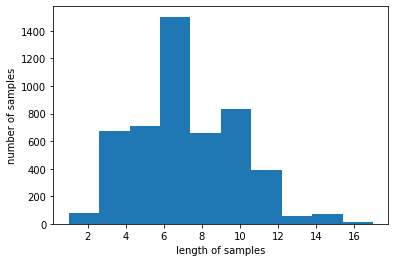

In [27]:
print('리뷰의 최대 길이 :', max(len(review) for review in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train])
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

`-` 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 12정도로 보인다

`-` 모든 샘플의 길이를 12로 맞추자

`-` 길이가 12보다 긴 문장은 짤리고 작은 문장은 0으로 채워진다

In [27]:
max_len = 12

In [28]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 모델링(LSTM)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
vocab_size ## 단어 사전의 크기

3003

In [53]:
tf.random.set_seed(22)

embedding_dim = 64
hidden_units = 64
hidden_units2 = 32

model = Sequential() ## 인스턴스 ## 신경망 구축
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim)) ## (3001, 128) 차원
model.add(LSTM(input_dim = embedding_dim, units = hidden_units)) ## (100, 128) 차원
model.add(Dense(input_dim = hidden_units, units = hidden_units2)) ## (100, 128) 차원
model.add(Dense(input_dim = hidden_units2, units = 1, activation = 'sigmoid')) ## 결과값이 확률(0과 1사이)이므로 시그모이드 사용, (128, 1) 차원

## verbose = 1 옵션은 진행 막대를 표시
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3) ## 검증 데이터 손실이 3회 증가하면 학습을 멈춤
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True) ## 가장 좋은 모델을 best_model.h5로 저장

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) ## 평가는 accuracy 사용
history = model.fit(X_train, y_train, epochs = 10, callbacks = [es, mc], batch_size = 16, validation_split = 0.2) ## train:valid = 0.8:0.2

Epoch 1/10
250/250 [==============================] - 4s 9ms/step - loss: 0.4381 - acc: 0.7835 - val_loss: 0.3358 - val_acc: 0.8547

Epoch 00001: val_acc improved from -inf to 0.85471, saving model to best_model.h5
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 0.2374 - acc: 0.9073 - val_loss: 0.3316 - val_acc: 0.8707

Epoch 00002: val_acc improved from 0.85471 to 0.87074, saving model to best_model.h5
Epoch 3/10
250/250 [==============================] - 1s 6ms/step - loss: 0.1917 - acc: 0.9213 - val_loss: 0.3519 - val_acc: 0.8617

Epoch 00003: val_acc did not improve from 0.87074
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.1679 - acc: 0.9366 - val_loss: 0.3441 - val_acc: 0.8517

Epoch 00004: val_acc did not improve from 0.87074
Epoch 5/10
250/250 [==============================] - 1s 6ms/step - loss: 0.1509 - acc: 0.9419 - val_loss: 0.3353 - val_acc: 0.8667

Epoch 00005: val_acc did not improve from 0.87074
Epoch 00005: early

In [54]:
loaded_model = load_model('best_model.h5')

In [55]:
loaded_model.fit(X_train, y_train, epochs = 2)

Epoch 1/2
156/156 [==============================] - 3s 8ms/step - loss: 0.2151 - acc: 0.9150
Epoch 2/2
156/156 [==============================] - 1s 6ms/step - loss: 0.1815 - acc: 0.9298


### 영화 리뷰 예측

`-` test 셋을 train을 가지고 학습시킨 model을 이용해 예측하자

In [56]:
pred = loaded_model.predict(X_test)

In [57]:
label = [1 if prob > 0.5 else 0 for prob in pred]

In [47]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/sample_submission.csv')

In [58]:
## 예측 값 넣어주기
submission['label'] = label

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,label
0,1,0
1,2,1
2,3,1
3,4,1
4,5,1


In [59]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/submission8.csv', index = False) 

`-` 점수는 0.862

## 1D CNN

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [85]:
tf.random.set_seed(22)

embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_split = 0.2, callbacks = [es, mc])

Epoch 1/10
63/63 [==============================] - 1s 5ms/step - loss: 0.6869 - acc: 0.5674 - val_loss: 0.6732 - val_acc: 0.7255

Epoch 00001: val_acc improved from -inf to 0.72545, saving model to best_model.h5
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6154 - acc: 0.7907 - val_loss: 0.5331 - val_acc: 0.8046

Epoch 00002: val_acc improved from 0.72545 to 0.80461, saving model to best_model.h5
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.4004 - acc: 0.8774 - val_loss: 0.3652 - val_acc: 0.8427

Epoch 00003: val_acc improved from 0.80461 to 0.84269, saving model to best_model.h5
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.2417 - acc: 0.9165 - val_loss: 0.3402 - val_acc: 0.8467

Epoch 00004: val_acc improved from 0.84269 to 0.84669, saving model to best_model.h5
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.1710 - acc: 0.9424 - val_loss: 0.3554 - val_acc: 0.8427

Epoch 00

In [337]:
loaded_model = load_model('best_model.h5')

### 영화 리뷰 예측

`-` test 셋을 train을 가지고 학습시킨 model을 이용해 예측하자

In [86]:
pred = loaded_model.predict(X_test)

In [87]:
label = [1 if prob > 0.5 else 0 for prob in pred]

In [340]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/sample_submission.csv')

In [88]:
## 예측 값 넣어주기
submission['label'] = label

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [90]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/submission5.csv', index = False) 

## Multi-Kernel 1D CNN

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [114]:
embedding_dim = 64
dropout_ratio = (0.5, 0.8)
num_filters = 64
hidden_units = 64

`-` 입력 층과 임베딩 층을 정의

In [115]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name = 'embedding')(model_input)
z = Dropout(dropout_ratio[0])(z)

`-` 3, 4, 5의 크기를 가지는 커널을 각각 128개 사용하고 이들을 맥스풀링

In [116]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                  kernel_size = sz,
                  padding = 'valid',
                  activation = 'relu',
                  strides = 1)(z)
    
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [117]:
tf.random.set_seed(22)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation = 'relu')(z)
model_output = Dense(1, activation = 'sigmoid')(z)

model = Model(model_input, model_output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('CNN_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_split = 0.2, verbose = 2, callbacks = [es, mc])

Epoch 1/10
63/63 - 2s - loss: 0.6938 - acc: 0.5098 - val_loss: 0.6855 - val_acc: 0.6503

Epoch 00001: val_acc improved from -inf to 0.65030, saving model to CNN_model.h5
Epoch 2/10
63/63 - 0s - loss: 0.6758 - acc: 0.5739 - val_loss: 0.6267 - val_acc: 0.7816

Epoch 00002: val_acc improved from 0.65030 to 0.78156, saving model to CNN_model.h5
Epoch 3/10
63/63 - 0s - loss: 0.5010 - acc: 0.7910 - val_loss: 0.3698 - val_acc: 0.8357

Epoch 00003: val_acc improved from 0.78156 to 0.83567, saving model to CNN_model.h5
Epoch 4/10
63/63 - 0s - loss: 0.3066 - acc: 0.8764 - val_loss: 0.3446 - val_acc: 0.8477

Epoch 00004: val_acc improved from 0.83567 to 0.84770, saving model to CNN_model.h5
Epoch 5/10
63/63 - 0s - loss: 0.2237 - acc: 0.9125 - val_loss: 0.3616 - val_acc: 0.8507

Epoch 00005: val_acc improved from 0.84770 to 0.85070, saving model to CNN_model.h5
Epoch 6/10
63/63 - 0s - loss: 0.1776 - acc: 0.9333 - val_loss: 0.3944 - val_acc: 0.8487

Epoch 00006: val_acc did not improve from 0.85070

### 영화 리뷰 예측

`-` test 셋을 train을 가지고 학습시킨 model을 이용해 예측하자

In [118]:
pred = model.predict(X_test)

In [119]:
label = [1 if prob > 0.5 else 0 for prob in pred]

In [340]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/sample_submission.csv')

In [120]:
## 예측 값 넣어주기
submission['label'] = label

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [121]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/submission6.csv', index = False) 

## 맞춤법 검사기 사용

### 맞춤법 검사

`-` 토큰화까지는 동일하고 맞춤법 검사만 추가했다

`-` 이후로는 동일하다

In [16]:
from py_hanspell_master.hanspell import spell_checker

`-` 각각의 문장에 대해 맞춤법 검사를 하자(시간 꽤 걸림)

In [95]:
data.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


In [96]:
data['document'] = data['document'].apply(lambda x: spell_checker.check(x).checked)
test['document'] = test['document'].apply(lambda x: spell_checker.check(x).checked)

`-` 이제 각각의 리뷰에 대해 품사 태깅을 하고 쓸모있는 품사만 골라내자

In [245]:
def text_tokenizer2(texts):
    main_pos = [] ## 데이터프레임의 새 컬럼이 될 리스트
    okt = Okt()
    for sentence in tqdm(texts): 
        pos = okt.pos(sentence) 
        main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ('Noun', 'Adverb', 'Adjective', 'Verb')] ## 가져오고자 하는 품사에 해당하면 해당 형태소를 추가
        main_words_str = ' '.join(main_words)  ## main_words 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join
        main_pos.append(main_words_str)  ## 선택한 형태소들로 이루어진 문자열을 최종 리스트에 추가
    
    return main_pos

In [246]:
data['main_pos'] = text_tokenizer2(data['document'])
test['main_pos'] = text_tokenizer2(test['document'])

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1185.48it/s]


`-` 4개의 품사를 제외한 나머지는 드랍했기에 결측치가 생겼을 수 있다

In [250]:
data['main_pos'].isnull().sum()

0

`-` 결측치는 없다

### 정수 인코딩(TF-IDF)

`-` TF-IDF 사용

`-` https://ko.wikipedia.org/wiki/Tf-idf

In [263]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [300]:
tfidf = TfidfVectorizer()

In [301]:
train_text = data.main_pos.tolist()
test_text = test.main_pos.tolist()

In [302]:
train_tfidf = tfidf.fit_transform(train_text).astype('float32')
test_tfidf = tfidf.transform(test_text).astype('float32')

In [303]:
label = np.asarray(data.label)

`-` 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됐다

### 모델링(로지스틱 회귀)

In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [330]:
tfidf = TfidfVectorizer(min_df = 0.0, analyzer = 'char', sublinear_tf = True,
                        ngram_range = (1,3), tokenizer = okt.morphs, max_features = 4300)

X = data['main_pos']
y = np.array(data.label)

X_train = tfidf.fit_transform(X)
X_test = tfidf.transform(test['document'])

logistic = LogisticRegression(class_weight = 'balanced')
logistic.fit(X_train, y)
label = logistic.predict(X_test)

### 영화 리뷰 예측

`-` test 셋을 train을 가지고 학습시킨 model을 이용해 예측하자

In [331]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/sample_submission.csv')

In [332]:
## 예측 값 넣어주기
submission['label'] = label

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [333]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/submission12.csv', index = False) 